In [1]:
pip install albumentations

Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
# os.environ["CUDA_LAUNCH_BLOCKING"] = '1'
import cv2
import time
import torch
import copy
import random

import torchvision
import numpy as np
import pandas as pd
from PIL import Image
from torch import nn
from sklearn import metrics
import matplotlib.pyplot as plt

import albumentations as A
from torchvision import models
from torchvision import datasets
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from albumentations.pytorch.transforms import ToTensorV2

torch.cuda.empty_cache()
random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)
np.random.seed(42)
# torch.backends.cudnn.benchmark = False
# torch.backends.cudnn.deterministic = True
# os.environ["CUBLAS_WORKSPACE_CONFIG"] = ':16:8'

In [3]:
class_dict = {'detergentes': 0,
 'carton': 1,
 'latas': 2,
 'frascos': 3,
 'botella de plastico': 4,
 'vidrio': 5}

In [4]:
def path_n_dict(root,train_ratio = None):
    path_im = []
    label_im = [] 
    for k in os.listdir(root):
        big_class = os.path.join(root,k)
        for i in os.listdir(big_class):
            per_class_path = os.path.join(big_class,i)
            for j in os.listdir(per_class_path):
                path_im.append(os.path.join(per_class_path,j)) 
                label_im.append(class_dict[i])
    if train_ratio :
        return train_test_split(path_im,label_im,train_size=train_ratio,random_state=42)
    return (path_im,label_im)

In [5]:
class MyDataset(Dataset):
    def __init__(self,path,label,transforms = None):
        self.path_image = path
        self.labels = label
        self.transforms = transforms
    def __len__(self):
        return len(self.labels)
    def __getitem__(self,idx):
        image = cv2.imread(self.path_image[idx])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        label = self.labels[idx]
        if self.transforms:
            image = self.transforms(image = image)
        return image,label

In [6]:
data_transforms = {
    'train': A.Compose(
    [   
        A.LongestMaxSize(max_size=456,interpolation = 2),
        A.PadIfNeeded(min_height=456, min_width=456),
        A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=90, p=0.8),
        A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
        A.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1, p=0.5),
        A.HorizontalFlip(),
        A.VerticalFlip(),
        A.CoarseDropout(max_holes=40, max_height=32, max_width=32, always_apply=True),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]
),
    'val': A.Compose(
    [   
        A.LongestMaxSize(max_size=456,interpolation = 2),
        A.PadIfNeeded(min_height=456, min_width=456),
#       A.CenterCrop(380,380,always_apply=True),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ])
}
g = torch.Generator()
g.manual_seed(42)

train_path,val_path,train_label,val_label = path_n_dict('/workspaces/TFM-Master4-0/TFM-Master4-0/Reutilizacion-codigo/train_crops',train_ratio = 0.8)
test_path,test_label = path_n_dict('/workspaces/TFM-Master4-0/TFM-Master4-0/Reutilizacion-codigo/test_crops')

train_dataset = MyDataset(train_path,train_label,transforms = data_transforms["train"])
val_dataset = MyDataset(val_path,val_label,transforms = data_transforms["val"])
test_dataset = MyDataset(test_path,test_label,transforms = data_transforms["val"] )


train_loader = DataLoader(train_dataset,batch_size = 4,shuffle=True, num_workers=0,generator=g,drop_last = True)
val_loader = DataLoader(val_dataset,batch_size = 4,shuffle=False, num_workers=0,generator=g)
test_loader = DataLoader(test_dataset,batch_size = 4,shuffle=False, num_workers=0,generator=g)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.6225708].


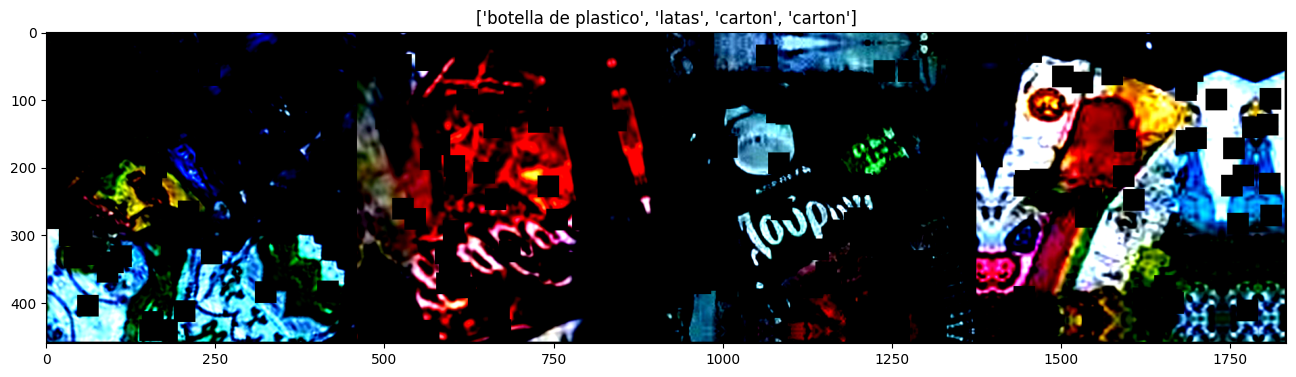

In [7]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    plt.figure(figsize=(16, 6))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

key_list = list(class_dict.keys())
inputs,classes = next(iter(train_loader))
out = torchvision.utils.make_grid(inputs['image'])

imshow(out, title=[key_list[x.item()] for x in classes])

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [9]:
# Cargar el modelo EfficientNet-B5 preentrenado y modificarlo
base_model = models.efficientnet_b5(weights='IMAGENET1K_V1')

# Modificar la capa de clasificación para 6 clases
base_model.classifier = nn.Sequential(*base_model.classifier,
                                      nn.BatchNorm1d(1000),
                                      nn.Linear(1000, 256),
                                      nn.ReLU(),
                                      nn.Dropout(0.4),
                                      nn.Linear(256, 6))  # Cambiar 28 a 6 clases

# Hacer el modelo compatible con múltiples GPUs
base_model = nn.DataParallel(base_model)
base_model.to(device)

# Definir el criterio de pérdida, optimizador y scheduler
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(base_model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=2, factor=0.25)



In [10]:
def train(model,criterion,optimizer,scheduler,epochs,resume_train = False,PATH = None):
    if resume_train:
        checkpoint = torch.load(PATH)
        model.load_state_dict(checkpoint['model_state_dict'])
        #optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_epoch = None
    best_acc = 0.0
    val_loss = 100.0
    t_list_loss = []
    t_list_acc = []
    v_list_loss = []
    v_list_acc = []
    for epoch in range(epochs):
        epoch_start = time.time()
        print("Epoch: {}/{}".format(epoch+1, epochs))

        model.train()

        train_loss = 0.0
        train_acc = 0.0

        val_loss = 0.0
        val_acc = 0.0

        for inputs,labels in train_loader:
            inputs = inputs['image']
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            preds = outputs.argmax(dim=1)
            loss = criterion(outputs,labels)
            loss.backward()

            optimizer.step()

            train_loss += loss.item()*inputs.size(0)
            train_acc += torch.sum(preds==labels)


        with torch.no_grad():
            model.eval()
            for inputs,labels in val_loader:
                inputs = inputs['image']
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                preds = outputs.argmax(dim=1)

                loss = criterion(outputs,labels)

                val_loss += loss.item()*inputs.size(0)
                val_acc += torch.sum(preds==labels)

        train_loss = train_loss/len(train_dataset)
        train_acc = train_acc.double()/len(train_dataset)

        val_loss = val_loss/(len(val_dataset))
        val_acc = val_acc.double()/(len(val_dataset))

        t_list_loss.append(train_loss)
        t_list_acc.append(train_acc)
        v_list_loss.append(val_loss)
        v_list_acc.append(val_acc)

        print(f'Train Loss: {train_loss:.4f} Acc: {train_acc:.4f}')
        print(f'Val Loss: {val_loss:.4f} Acc: {val_acc:.4f} ')
        scheduler.step(val_acc)

        if ((val_acc>best_acc) or ((val_acc==best_acc) and (val_loss<best_loss))) :
            best_acc = val_acc
            best_epoch = epoch+1
            best_model_wts = copy.deepcopy(model.state_dict())
            best_loss = val_loss

    total_time = time.time() - start
    print(f'Training complete in {total_time // 60:.0f}m {total_time % 60:.0f}s')
    print(f'Best val Epoch: {best_epoch:4f}')
    print(f'Val Acc: {best_acc:4f}')
    model.load_state_dict(best_model_wts)
    print("model:",model)
    return model,t_list_loss,t_list_acc,v_list_loss,v_list_acc

In [11]:
# Número de épocas
epochs = 40

# Entrenamiento del modelo
model_trained, t_list_loss, t_list_acc, v_list_loss, v_list_acc = train(
    base_model,
    criterion,
    optimizer,
    scheduler,
    epochs,
    resume_train=False,
    PATH='/workspaces/TFM-Master4-0/TFM-Master4-0/Reutilizacion-codigo/model_b5.pt'  # Cambia esta ruta según tu necesidad
)

# Guardar el modelo y el estado del optimizador
torch.save({
    'model_state_dict': model_trained.state_dict(),
    'optimizer_state_dict': optimizer.state_dict()
}, '/workspaces/TFM-Master4-0/TFM-Master4-0/Reutilizacion-codigo/model_b5_1.pt')  # Cambia esta ruta según tu necesidad


Epoch: 1/40


KeyboardInterrupt: 

In [ ]:
def cov_2_np(the_list):
  new_list = []
  for i in the_list:
    new_list.append(i)
  return new_list
t_list_acc = cov_2_np(t_list_acc)
v_list_acc = cov_2_np(v_list_acc)

In [ ]:
def test(model):
    start = time.time()
    y_ = []
    y = []
    with torch.no_grad():
        model.eval()
        test_loss = 0.0
        test_acc = 0.0
        for inputs,labels in test_loader:
                inputs = inputs['image']
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                preds = outputs.argmax(dim=1)
                y = np.concatenate((y,labels.cpu().detach().numpy()))
                y_ = np.concatenate((y_,preds.cpu().detach().numpy()))
                loss = criterion(outputs,labels)

                test_loss += loss.item()*inputs.size(0)
                test_acc += torch.sum(preds==labels)
        test_loss = test_loss/len(test_dataset)
        test_acc = test_acc.double()/len(test_dataset)
    print(f'Test Loss: {test_loss:.4f} Acc: {test_acc:.4f}')
    total_time = time.time() - start
    print(f'Testing complete in {total_time // 60:.0f}m {total_time % 60:.0f}s')
    return y,y_

In [ ]:
true_label, predict_label = test(model_trained)

In [ ]:
confusion_matrix = metrics.confusion_matrix(true_label, predict_label)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix)
plt.subplots_adjust(bottom=0.2)
cm_display.plot(cmap = 'Blues')
plt.show()